<a href="https://colab.research.google.com/github/yakovsushenok/Thesis/blob/main/PreProcessing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from google.colab import drive
from sklearn.model_selection import StratifiedShuffleSplit
drive.mount('/content/gdrive')
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
try:
    from scipy.fftpack import fft, ifft
except ImportError:
    from numpy.fft import fft, ifft
from scipy.signal import lfilter
import scipy.io as sio
from scipy import signal
import gc
import h5py
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Mounted at /content/gdrive


In [2]:
df_500 = pd.read_csv("/content/gdrive/MyDrive/train_metadata_more_than_500.csv")
df_500['primary_label'] = df_500['primary_label'].apply(lambda x: x - 1)
df_500 = df_500[['relative_path', 'primary_label']]
df_500_toy = pd.read_csv("/content/gdrive/MyDrive/df_500_toy.csv")
toy_ind = list(df_500_toy['Unnamed: 0'])

In [3]:
class H5DS(Dataset):
  def __init__(self, df, path, toy_ind):
    self.path = path
    self.data = h5py.File(self.path, 'r')['data']
    self.df = df
    self.toy_ind = toy_ind
  
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
   
   return (self.data[toy_ind[idx]], torch.tensor(self.df['primary_label'].iloc[idx]))

def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (7 + (inputs - inputs_m) / inputs_s)
      # Get predictions
      outputs = model(inputs.float())

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Val Accuracy: {acc:.2f}')

In [ ]:
tensors = h5py.File('/content/gdrive/MyDrive/df_train_tensor_60_fs50-8k.h5', 'r') 
random_sample = random.sample(range(0, 6000), 2000)
random_sample.sort()
tensors_toy = h5py.File('/content/gdrive/MyDrive/df_train_tensor_60_fs50-8k_toy.h5', 'w') 
N = len(random_sample)
data = tensors_toy.create_dataset('data', shape=(N, 768, 2031), dtype=np.float32, fillvalue=0)
data[:] = tensors['data'][random_sample]

# Models

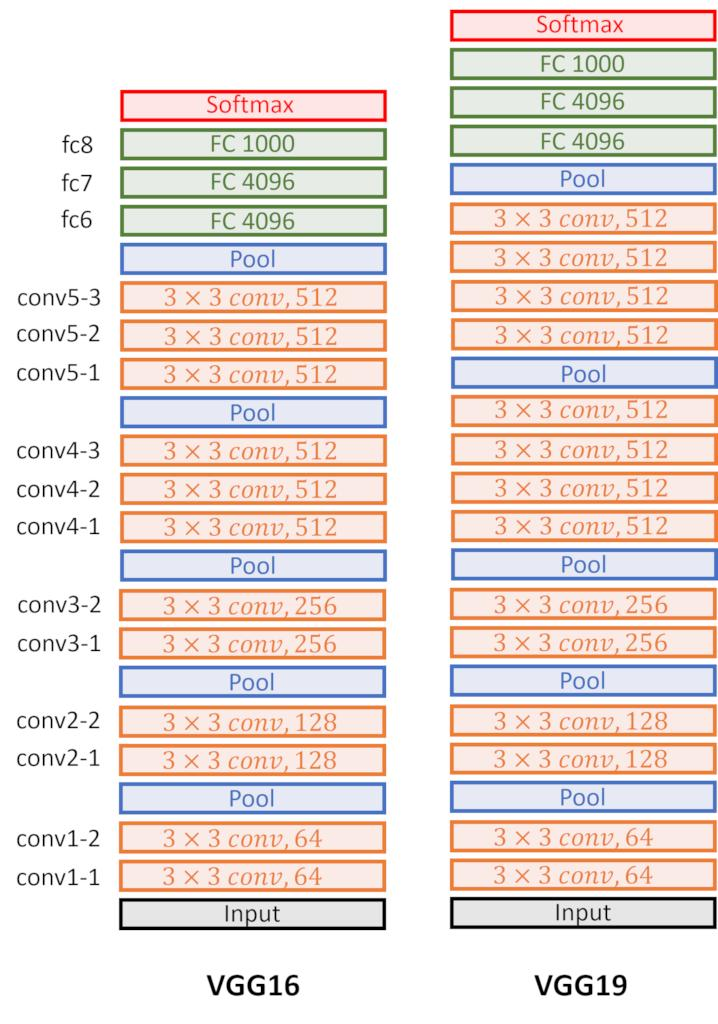

In [4]:




# CNN2
class AudioClassifier(nn.Module): 
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 50, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(50,20,3)
        self.fc = nn.Linear(7711440,12)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)       
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# AlexNet (modified) 
class AudioClassifier(nn.Module):
      def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 25, stride = 10)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride = 2)
        self.conv2 = nn.Conv2d(96,256, kernel_size = 10, padding = 6)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv3 = nn.Conv2d(256, 384, padding = 3, kernel_size = 5)
        self.conv4 = nn.Conv2d(384, 384, padding = 3, kernel_size = 5)
        self.conv5 = nn.Conv2d(384, 256, padding = 3, kernel_size = 5)
        self.dropout = nn.Dropout(p = 0.25)
        self.fc1 = nn.Linear(86016 , 2500)
        self.fc2 = nn.Linear(2500, 1000)
        self.output = nn.Linear(1000,12)
        self.relu = nn.ReLU()
      
      def forward(self, x):
        
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.maxpool2(x)
        x = nn.Flatten()(x)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.output(x)
        return x



In [ ]:
class AudioClassifier(nn.Module): 
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 100, 5)
        self.batchnorm1 = nn.BatchNorm2d(100) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(100,50,5)
        self.batchnorm2 = nn.BatchNorm2d(50) 
        self.conv3 = nn.Conv2d(50,50,3)
        self.conv4 = nn.Conv2d(50, 20, 3)
        self.batchnorm3 = nn.BatchNorm2d(20)   
        self.fc1 = nn.Linear(349200,12)
        self.flatten = nn.Flatten(start_dim = 1)
        
    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)   
        x = self.batchnorm2(x)    
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

class H5DS(Dataset):
  def __init__(self, df, path):
    self.path = path
    self.data = h5py.File(self.path, 'r')['data']
    self.df = df
    self.toy_ind = toy_ind
  
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
   
   return (self.data[idx], torch.tensor(self.df['primary_label'].iloc[idx]))

# Create the model and put it on the GPU if available
myModel = AudioClassifier(768*2031, 12)
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu") #
myModel = myModel.to(device)

def training(model, train_dl, num_epochs, val_dl):
  # Loss Function, Optimizer 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
  
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00001,
  #                                               steps_per_epoch=int(len(train_dl)),
  #                                               epochs=num_epochs,
  #                                               anneal_strategy='linear')

  # Epoch iterator
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    indices = []
    # Batch iterator
    j = 0
    for i, data in enumerate(train_dl):

        inputs, labels = torch.tensor(data[0]).to(device), torch.tensor(data[1]).to(device) # Get the input features and target labels, and put them on the GPU
        if torch.isnan(torch.tensor(data[0])).any() == True:
          j += 1
          continue
        # Normalize the inputs - 1 (ignore the 7). We normalize the tensors using the mean from the whole dataset, not per-image.https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (7 + (inputs - inputs_m) / inputs_s)

        
        optimizer.zero_grad() # Zero the parameter gradients

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        running_loss += loss.item() # Keep stats for Loss and Accuracy

        _, prediction = torch.max(outputs,1) # Get the predicted class with the highest score
        #print(prediction, labels)
        correct_prediction += (prediction == labels).sum().item() # Count of predictions that matched the target label
        total_prediction += prediction.shape[0]

    
    # Print stats at the end of the epoch
    print(j)
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    print(f"TESTING:")
    inference(model, val_dl)
    print("\n")

  print('Finished Training')


path = '/content/gdrive/MyDrive/df_train_tensor_60_fs50-8k.h5' #               '/content/gdrive/MyDrive/df_train_tensor_60_500.h5'
NUM_EPOCHS = 30
# Initializing the dataset
myds = H5DS(df_500, path)
# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items*(0.80))
num_val = num_items - num_train
print(num_train,num_val)
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)

training(myModel, train_dl, NUM_EPOCHS, val_dl) # Training

4800 1200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1
Epoch: 1, Loss: 2.70, Accuracy: 0.27
TESTING:
Val Accuracy: 0.38


1
Epoch: 2, Loss: 1.37, Accuracy: 0.58
TESTING:
Val Accuracy: 0.42


1
Epoch: 3, Loss: 0.67, Accuracy: 0.78
TESTING:
Val Accuracy: 0.46


1
Epoch: 4, Loss: 0.33, Accuracy: 0.89
TESTING:
Val Accuracy: 0.47


1
Epoch: 5, Loss: 0.23, Accuracy: 0.93
TESTING:
Val Accuracy: 0.47


1
Epoch: 6, Loss: 0.15, Accuracy: 0.96
TESTING:
Val Accuracy: 0.47


1
Epoch: 7, Loss: 0.11, Accuracy: 0.97
TESTING:
Val Accuracy: 0.50


1
Epoch: 8, Loss: 0.08, Accuracy: 0.98
TESTING:
Val Accuracy: 0.53


1
Epoch: 9, Loss: 0.09, Accuracy: 0.97
TESTING:
Val Accuracy: 0.48


1
Epoch: 10, Loss: 0.07, Accuracy: 0.98
TESTING:
Val Accuracy: 0.47


1
Epoch: 11, Loss: 0.07, Accuracy: 0.98
TESTING:
Val Accuracy: 0.53


1
Epoch: 12, Loss: 0.04, Accuracy: 0.99
TESTING:
Val Accuracy: 0.51


1
Epoch: 13, Loss: 0.04, Accuracy: 0.99
TESTING:
Val Accuracy: 0.51


1
Epoch: 14, Loss: 0.04, Accuracy: 0.99
TESTING:
Val Accuracy: 0.54


1
Epoch: 15, Loss: 0.04, Accu

# Results

---
Sample Length (s) : 20  $|$ _  $|$ _ $|$ _ $|$ 60 $|$ 60

Model:

```
        self.conv1 = nn.Conv2d(1, 50, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(50,20,3)
        self.fc = nn.Linear(7711440,12)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
```

Normalization: Yes $|$ Yes $|$ Yes $|$ No $|$ Yes $|$ Yes

Mini-batch size = 10 $|$ _ $|$ 10 $|$ 1 $|$ 1

Number of Samples in training: 2000*(0.8) $|$ 6000*(0.9) $|$ 6000*(0.8) $|$ 2000*(0.8) $|$ 2000*(0.8) $|$ 2000*(0.8)

`fs = [1000,20000]` $|$ _ $|$ _ $|$_ $|$ `fs = [50,8000]` $|$ `fs = [1000,20000]`

Best Val Accurary = 0.29 at epoch 2 $|$ _ $|$ 0.39 epoch 2 $|$ 0.29 epoch 5  $|$ 0.28 epoch 1 $|$ 0.25 at epoch 2

Input shape: `(768, 2031)` $|$ _ $|$ _ $|$ _  $|$ `(768, 6025)`


Trainable params: 92,546,812 $|$ _ $|$ _ $|$ _ $|$ 24,614,292 $|$ 24,614,292

---

Sample Length (s) : 20

Model: 

```
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(16,10,3)
        self.fc = nn.Linear(3841800,12)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
```

Normalization: Yes

Number of classes: 12

Mini-batch size = 5

Number of Samples in training: 1000*(0.8)

`fs = [1000,20000]`

Best Val Accurary = 0.14 

Input shape: `(768, 2031)`


Trainable params: 46,103,478

---

Sample Length (s) : 20

Model: 

```
        self.conv1 = nn.Conv2d(1, 100, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(100,50,3)
        self.conv3 = nn.Conv2d(50,20,3)
        self.fc = nn.Linear(473760,12)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
```

Normalization: Yes

Number of classes: 12

Mini-batch size = 5

Number of Samples in training: 1000*(0.8)

`fs = [1000,20000]`

Best Val Accurary = 0.23 epoch 10

Input shape: `(768, 2031)`


Trainable params: 5,740,202



---

Sample Length (s) : 20

Model: CNN2

```
        self.conv1 = nn.Conv2d(1, 50, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(50,20,3)
        self.fc1 = nn.Linear(7711440,50)
        self.fc2 = nn.Linear(50,12)
       
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
```

Normalization: Yes

Number of classes: 12

Mini-batch size = 5

Number of Samples in training: 1000*(0.8)

`fs = [1000,20000]`

Best Val Accurary = 0.10 epoch 10

Input shape: `(768, 2031)`


Trainable params: 385,582,182

---



Sample Length (s) : 20

Model: AlexNet (Modified)

```
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 25, stride = 10)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride = 2)
        self.conv2 = nn.Conv2d(96,256, kernel_size = 10, padding = 6)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv3 = nn.Conv2d(256, 384, padding = 3, kernel_size = 5)
        self.conv4 = nn.Conv2d(384, 384, padding = 3, kernel_size = 5)
        self.conv5 = nn.Conv2d(384, 256, padding = 3, kernel_size = 5)
        self.dropout = nn.Dropout(p = 0.25)
        self.fc1 = nn.Linear(86016 , 2500)
        self.fc2 = nn.Linear(2500, 1000)
        self.output = nn.Linear(1000,12)
        self.relu = nn.ReLU()
      
      def forward(self, x):
        
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.maxpool2(x)
        x = nn.Flatten()(x)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.output(x)
        return x
```

Normalization: Yes

Number of classes: 12

Mini-batch size = 10

Number of Samples in training: 2000*(0.8)

`fs = [1000,20000]`

Best Val Accurary = 0.10 

Input shape: `(768, 2031)`


Trainable params:  24,614,292 

--- 

Sample Length (s) : 20

Model: CNN2 with batch normalization

```
      self.conv1 = nn.Conv2d(1, 50, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(50,20,3)
        self.fc = nn.Linear(23789640,12)
        self.flatten = nn.Flatten(start_dim = 1)
        self.batchnorm1 = nn.BatchNorm2d(50)   
        self.batchnorm2 = nn.BatchNorm2d(20)  
        

    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)   
        x = self.batchnorm2(x)    
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
```

Normalization: Yes

Number of classes: 12

Mini-batch size = 1

Number of Samples in training: 2000*(0.8)

`fs = [50,8000]`

Best Val Accurary = 0.29 epoch 8

Input shape: `(768, 2031)`


Trainable params:  285,485,352


---

Sample Length (s) : 60

Model: 

```
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.batchnorm1 = nn.BatchNorm2d(100) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(100,50,5)
        self.batchnorm2 = nn.BatchNorm2d(50) 
        self.conv3 = nn.Conv2d(50,50,3)
        self.conv4 = nn.Conv2d(50, 20, 3)
        self.batchnorm3 = nn.BatchNorm2d(20)   
        self.fc1 = nn.Linear(349200,12)
        self.flatten = nn.Flatten(start_dim = 1)
        
    def forward(self, x):
        x = x[None, :, :, :]
        x = x.permute(1, 0, 2, 3)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)   
        x = self.batchnorm2(x)    
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x
```
Normalization: Yes $|$ Yes $|$ Yes

Number of classes: 12

Mini-batch size = 1

Number of Samples in training: 2000*(0.8) $|$ 2000*(0.8) $|$ 6000*(0.8)

`fs = [50,8000]`

Best Val Accurary = 0.29 epoch 4 $|$ 0.35 epoch 12 (lr = 0.00001, no scheduler)  $|$ $|$ 0.54 epoch 14 (lr = 0.00001, no scheduler)

Input shape: `(768, 6025)`


Trainable Params: 4,349,972 







In [6]:

model = AudioClassifier(768*2031, 12)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,349,972 trainable parameters
